# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Compare relu variants
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Re-organize the data: train/test in DataLoaders

In [11]:
def get_dataloaders(data, quality_threshold: float):

  # data['boolQuality'] = 0
  data['boolQuality'] = (data['quality'] > quality_threshold).astype(int)

  # convert from pandas dataframe to tensor
  dataT  = torch.tensor( data[cols2zscore].values ).float()
  labels = torch.tensor( data['boolQuality'].values ).float()
  labels = labels[:,None] # transform to matrix

  # use scikitlearn to split the data
  train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = torch.utils.data.TensorDataset(train_data,train_labels)
  test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

  # finally, translate into dataloader objects
  batchsize    = 64
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

  return train_loader, test_loader

# Now for the DL part

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun
  
  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

# Train the model

In [6]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel(quality_threshold: float):

  train_loader, test_loader = get_dataloaders(data, quality_threshold)

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [36]:
quality_thresholds = np.arange(4.5, 7.5, 1.0)

# initialize performance matrix
all_test_acc = np.zeros((len(quality_thresholds), numepochs))
all_train_acc = np.zeros((len(quality_thresholds), numepochs))
all_losses_acc = np.zeros((len(quality_thresholds), numepochs))

all_outputs = []

for ql_idx, ql_thresh in enumerate(quality_thresholds):
  # create a model and train it
  winenet = ANNwine('LeakyReLU')
  trainAcc, testAcc, losses = trainTheModel(ql_thresh)

  all_test_acc[ql_idx] = testAcc
  all_train_acc[ql_idx] = trainAcc
  all_losses_acc[ql_idx] = losses

  quality_data = (data['quality'] > ql_thresh).astype(float)

  # Get evaluation data
  winenet.eval()
  test_loader = get_dataloaders(data, ql_thresh)[1]
  X = next(iter(test_loader))[0]
  with torch.no_grad(): # deactivates autograd
    yHat = winenet(X)
  yHat = (yHat.detach().numpy().flatten() > 0).astype(int)
  all_outputs.append(yHat)

  print(f"Finished threshold at {ql_thresh} [{100 * np.mean(quality_data):.2f}% balance]")

all_outputs = np.array(all_outputs)

Finished threshold at 4.5 [96.06% balance]
Finished threshold at 5.5 [53.41% balance]
Finished threshold at 6.5 [13.46% balance]


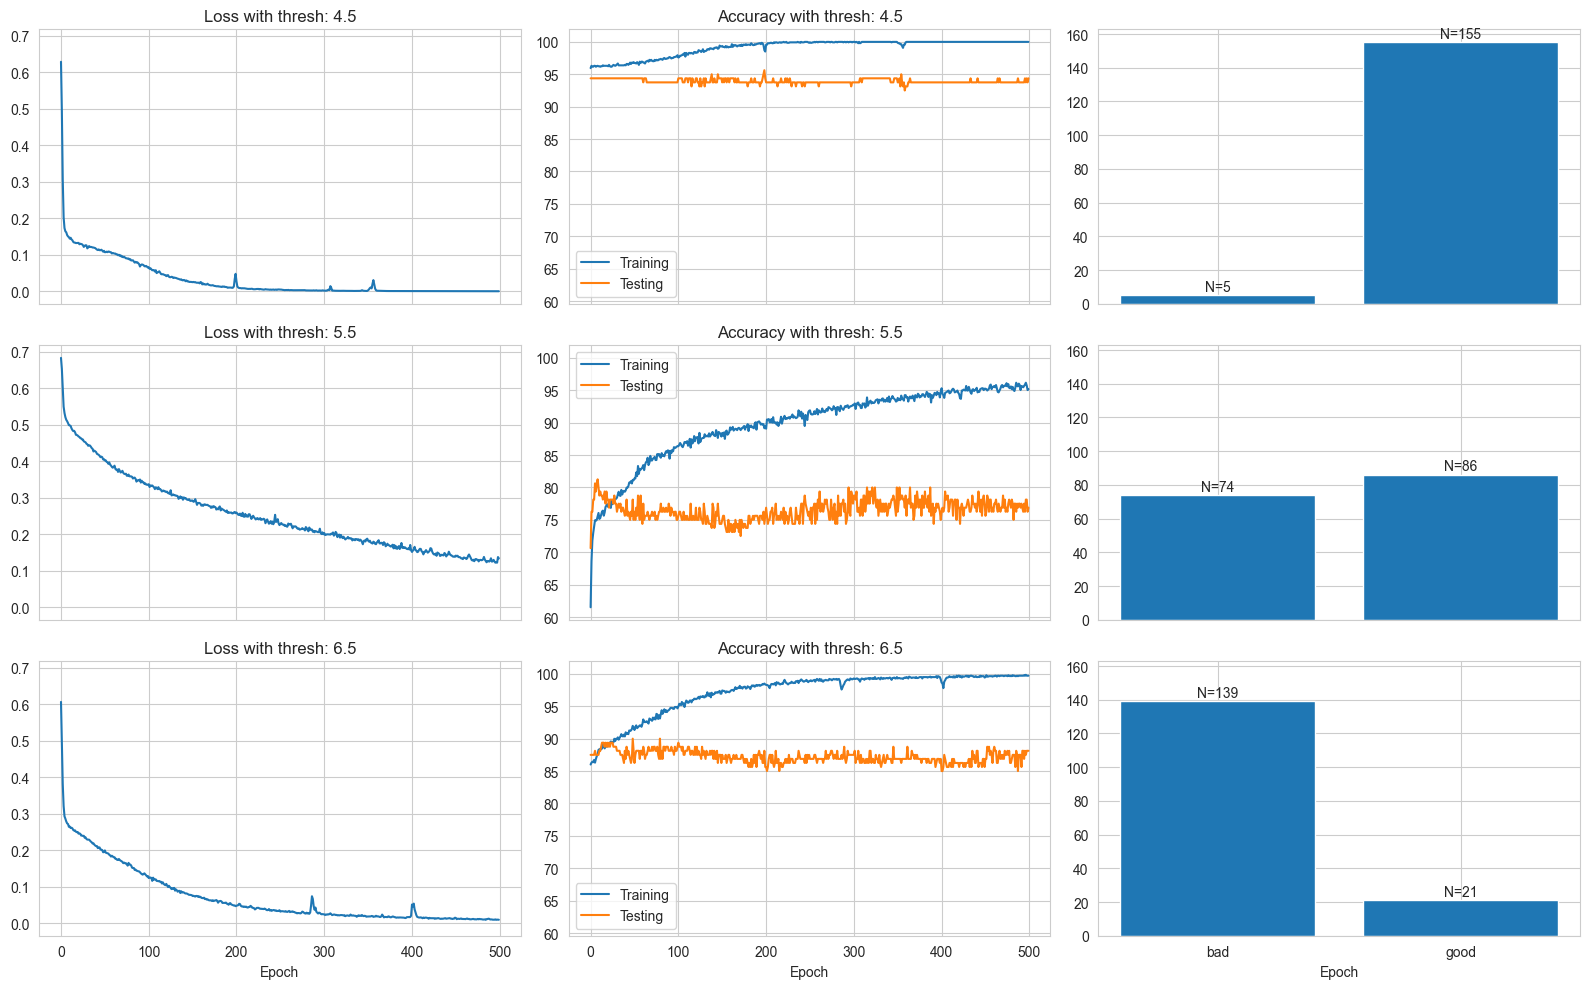

In [42]:
fig, axs = plt.subplots(3, 3, sharex="col", sharey='col', figsize=(16, 10))

for ql_idx, ql_thresh in enumerate(quality_thresholds):
  axs[ql_idx][0].set_title(f"Loss with thresh: {quality_thresholds[ql_idx]}")
  axs[ql_idx][0].plot(all_losses_acc[ql_idx])

  axs[ql_idx][1].set_title(f"Accuracy with thresh: {quality_thresholds[ql_idx]}")
  axs[ql_idx][1].plot(all_train_acc[ql_idx], label='Training')
  axs[ql_idx][1].plot(all_test_acc[ql_idx], label='Testing')
  axs[ql_idx][1].legend()

  good = np.sum(all_outputs[ql_idx])
  bad = all_outputs[ql_idx].size - good
  axs[ql_idx][2].bar(['bad', 'good'], [bad, good])
  axs[ql_idx][2].text(0, bad + 5, f"N={bad}", ha="center", va="center")
  axs[ql_idx][2].text(1, good + 5, f"N={good}", ha="center", va="center")


for axid in range(3):
  axs[2][axid].set_xlabel("Epoch")

plt.tight_layout()
plt.show()

In [33]:
all_outputs = []
winenet.eval()
test_loader = get_dataloaders(data, 6.5)[1]
X = next(iter(test_loader))[0]
with torch.no_grad(): # deactivates autograd
  yHat = winenet(X)
yHat = (yHat.detach().numpy().flatten() > 0).astype(int)
all_outputs.append(yHat)

In [35]:
np.array(all_outputs).size

160